In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import norm
from dataclasses import dataclass
import requests
import datetime as dt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

# The Black-Scholes model

The Black-Scholes model is a funtion of time, stock price, implied volatility and the interest rate. 

The sensitivity of an option to the variables above is called the "Greeks".

## 1st order greeks: ##

Delta: The delta of a call option indicates how much its price changes in response to changes in the underlying asset price. It can range from 0 to 1 for a call option, and from -1 to 0 for a put option. The delta tells us how closely the option price tracks the movements of the underlying asset.

Theta: represents the time decay of an option's value. It tell us how much the option price decreases over time due to the passage of time. In theory limits for theta are not explicitly defined because they depend on multiple factors like time to expiration, volatility, and interest rates.

Rho: It indicates how much the option price changes when interest rates fluctuate. Values for rho generally range from 0 to positive infinity, and for put options, it ranges from negative infinity to 0.

Vega: Shows how much the option price changes in response to changes in the volatility of the underlying asset. The limits for vega are not explicitly defined as they depend on the pricing model and other factors. Vega is typically positive for both call and put options.

## 2nd order greeks

Gamma: Indicates how quickly the delta of an option adjusts to movements in the underlying asset. Gamma limits are not specifically stated, but it tends to be higher for options that are close to the current market price and decreases as options move further away from that price.

Volga: Volga, also known as vega convexity, captures the sensitivity of vega to changes in volatility. It shows how vega itself changes as volatility fluctuates. Limits for volga are not explicitly defined and depend on the pricing model and other factors.

Vanna: shows how the delta of the option changes in response to shifts in volatility. The values vanna can take are not explicitly stated and depend on the pricing model and other factors.

In [2]:
class EuroOpt_BS:
    def __init__(self, S, K, T, r, q, sigma, Type):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.q = q        
        self.sigma = sigma
        self.Type = Type
        self.d1 = self.d1()
        self.d2 = self.d2()
        self.price = self.price()
        self.delta = self.delta()
        self.theta = self.theta()
        self.rho = self.rho()
        self.vega = self.vega()
        self.gamma = self.gamma()
        self.volga = self.volga()
        self.vanna = self.vanna()  

    def d1(self):
        d1 = (math.log(self.S / self.K) \
                   + (self.r - self.q + .5 * (self.sigma ** 2)) * self.T) \
                    / (self.sigma * self.T ** .5)       
        return d1

    def d2(self):
        d2 = self.d1 - self.sigma * self.T ** .5     
        return d2
    
    def price(self):
        if self.Type == "Call":
            price = self.S * math.exp(-self.q * self.T) * norm.cdf(self.d1) \
            - self.K * math.exp(-self.r * self.T) * norm.cdf(self.d2)
        if self.Type == "Put":
            price = self.K * math.exp(-self.r * self.T) * norm.cdf(-self.d2) \
            - self.S * math.exp(-self.q * self.T) * norm.cdf(-self.d1)            
        return price
    
    def delta(self):
        if self.Type == "Call":
            delta = math.exp(-self.q * self.T) * norm.cdf(self.d1)
        if self.Type == "Put":
            delta = -math.exp(-self.q * self.T) * norm.cdf(-self.d1)
        return delta
    
    def theta(self):
        if self.Type == "Call":
            theta1 = -math.exp(-self.q * self.T) * \
            (self.S * norm.pdf(self.d1) * self.sigma) / (2 * self.T ** .5)
            theta2 = self.q * self.S * math.exp(-self.q * self.T) * norm.cdf(self.d1)
            theta3 = -self.r * self.K * math.exp(-self.r * self.T) * norm.cdf(self.d2)
            theta = theta1 + theta2 + theta3
        if self.Type == "Put":
            theta1 = -math.exp(-self.q * self.T) * \
            (self.S * norm.pdf(self.d1) * self.sigma) / (2 * self.T ** .5)
            theta2 = -self.q * self.S * math.exp(-self.q * self.T) * norm.cdf(-self.d1)
            theta3 = self.r * self.K * math.exp(-self.r * self.T) * norm.cdf(-self.d2)
            theta =  theta1 + theta2 + theta3
        return theta
    
    def rho(self):
        if self.Type == "Call":
            rho = self.K*self.T*math.exp(-self.r*self.T)*norm.cdf(self.d2, 0, 1)
        elif self.Type == "Put":
            rho = -self.K*self.T*math.exp(-self.r*self.T)*norm.cdf(-self.d2, 0, 1)
        return rho
    
    def vega(self):
        vega = self.S * math.exp(-self.q * self.T) * self.T** .5 * norm.pdf(self.d1)
        return vega
    
    def gamma(self):
        gamma = math.exp(-self.q * self.T) * norm.pdf(self.d1) / (self.S * self.sigma * self.T** .5)
        return gamma
    
    def volga(self):
        volga = self.vega / self.sigma * self.d1 * self.d2
        return volga
    
    def vanna(self):
        vanna = -self.vega / (self.S * self.sigma * self.T** .5) * self.d2
        return vanna

# Get option contracts with 

In [3]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time

In [4]:
driver = webdriver.Chrome()
page = 'https://finance.yahoo.com/quote/%5ERUT/options?p=%5ERUT'
driver.get(page)
driver.maximize_window()
time.sleep(1)

# Use selenium click() to accept cookies
driver.find_element(By.XPATH, '//*[@id="scroll-down-btn"]').click()
time.sleep(1)
driver.find_element(By.XPATH, '//*[@id="consent-page"]/div/div/div/form/div[2]/div[2]/button[1]').click()
time.sleep(1)

In [5]:
# get dates available
dates = driver.find_elements(By.XPATH, '//*[@id="Col1-1-OptionContracts-Proxy"]/section/div/div[1]/select')[0].text.split('\n')
dates_df = pd.DataFrame(dates).rename(columns={0:'Date'})['Date'].apply(lambda x: pd.to_datetime(x))

In [6]:
df_calls = {}
for i in range(1, len(dates)+1):
    try:
        element = driver.find_element(By.XPATH, '//*[@id="Col1-1-OptionContracts-Proxy"]/section/section[1]/div[2]/div/table')
        contract_date = driver.find_element(By.XPATH, f'//*[@id="Col1-1-OptionContracts-Proxy"]/section/div/div[1]/select/option[{i}]').text
    except:
        print(f'Page numeber {i} with contracts for {contract_date} without data')
        continue
    else:
        df_temp = pd.read_html(element.get_attribute('outerHTML'))[0]
        df_temp['Expiration_date'] = dates_df[i-1]
        if i <= len(dates):
            driver.find_element(By.XPATH, f'//*[@id="Col1-1-OptionContracts-Proxy"]/section/div/div[1]/select/option[{i}]').click()
            time.sleep(1)
            df_calls[i] = df_temp
        else:
            print('All pages scraped')

driver.close()

In [7]:
df_calls = pd.concat([v for k,v in df_calls.items()], axis=0)
df_calls

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Expiration_date
0,RUTW230605C01690000,2023-05-31 11:37AM EDT,1690.0,51.72,140.2,145.1,51.72,-,-,2,92.53%,2023-06-05
1,RUTW230605C01700000,2023-05-31 11:37AM EDT,1700.0,43.19,130.2,135.1,43.19,-,-,2,87.01%,2023-06-05
2,RUTW230605C01720000,2023-06-02 1:29PM EDT,1720.0,103.42,110.2,115.1,41.50,+67.02%,10,10,75.88%,2023-06-05
3,RUTW230605C01730000,2023-06-02 10:28AM EDT,1730.0,71.34,100.2,105.1,71.34,-,20,20,70.26%,2023-06-05
4,RUTW230605C01740000,2023-06-02 2:48PM EDT,1740.0,84.92,90.3,95.1,84.92,-,12,15,65.01%,2023-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...
30,RUT241220C02950000,2022-08-26 9:42AM EDT,2950.0,44.50,11.5,21.5,0.00,-,1,1,25.56%,2025-12-19
31,RUT241220C03000000,2023-05-23 11:31AM EDT,3000.0,2.40,2.5,4.0,0.00,-,1,539,19.24%,2025-12-19
32,RUT241220C03100000,2022-12-28 11:45AM EDT,3100.0,7.90,0.4,10.0,0.00,-,-,2,23.56%,2025-12-19
33,RUT241220C03150000,2023-06-02 1:53PM EDT,3150.0,1.70,0.0,1.9,-6.30,-78.75%,2,61,18.76%,2025-12-19


In [8]:
df_calls.Maturity = pd.to_datetime(df_calls.Expiration_date)
df_calls['Time to expiration'] = df_calls.Maturity -  dt.datetime.today()
df_calls

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Expiration_date,Time to expiration
0,RUTW230605C01690000,2023-05-31 11:37AM EDT,1690.0,51.72,140.2,145.1,51.72,-,-,2,92.53%,2023-06-05,-1 days +20:39:08.124103
1,RUTW230605C01700000,2023-05-31 11:37AM EDT,1700.0,43.19,130.2,135.1,43.19,-,-,2,87.01%,2023-06-05,-1 days +20:39:08.124103
2,RUTW230605C01720000,2023-06-02 1:29PM EDT,1720.0,103.42,110.2,115.1,41.50,+67.02%,10,10,75.88%,2023-06-05,-1 days +20:39:08.124103
3,RUTW230605C01730000,2023-06-02 10:28AM EDT,1730.0,71.34,100.2,105.1,71.34,-,20,20,70.26%,2023-06-05,-1 days +20:39:08.124103
4,RUTW230605C01740000,2023-06-02 2:48PM EDT,1740.0,84.92,90.3,95.1,84.92,-,12,15,65.01%,2023-06-05,-1 days +20:39:08.124103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,RUT241220C02950000,2022-08-26 9:42AM EDT,2950.0,44.50,11.5,21.5,0.00,-,1,1,25.56%,2025-12-19,927 days 20:39:08.124103
31,RUT241220C03000000,2023-05-23 11:31AM EDT,3000.0,2.40,2.5,4.0,0.00,-,1,539,19.24%,2025-12-19,927 days 20:39:08.124103
32,RUT241220C03100000,2022-12-28 11:45AM EDT,3100.0,7.90,0.4,10.0,0.00,-,-,2,23.56%,2025-12-19,927 days 20:39:08.124103
33,RUT241220C03150000,2023-06-02 1:53PM EDT,3150.0,1.70,0.0,1.9,-6.30,-78.75%,2,61,18.76%,2025-12-19,927 days 20:39:08.124103


In [9]:
df_calls['Implied Volatility'] = df_calls['Implied Volatility'].str.replace('%','')
df_calls['Implied Volatility'] = df_calls['Implied Volatility'].str.replace(',','')
df_calls['Implied Volatility'] = pd.to_numeric(df_calls['Implied Volatility'])

In [10]:
df_calls['Implied Volatility'] = df_calls['Implied Volatility']/100
df_calls

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Expiration_date,Time to expiration
0,RUTW230605C01690000,2023-05-31 11:37AM EDT,1690.0,51.72,140.2,145.1,51.72,-,-,2,0.9253,2023-06-05,-1 days +20:39:08.124103
1,RUTW230605C01700000,2023-05-31 11:37AM EDT,1700.0,43.19,130.2,135.1,43.19,-,-,2,0.8701,2023-06-05,-1 days +20:39:08.124103
2,RUTW230605C01720000,2023-06-02 1:29PM EDT,1720.0,103.42,110.2,115.1,41.50,+67.02%,10,10,0.7588,2023-06-05,-1 days +20:39:08.124103
3,RUTW230605C01730000,2023-06-02 10:28AM EDT,1730.0,71.34,100.2,105.1,71.34,-,20,20,0.7026,2023-06-05,-1 days +20:39:08.124103
4,RUTW230605C01740000,2023-06-02 2:48PM EDT,1740.0,84.92,90.3,95.1,84.92,-,12,15,0.6501,2023-06-05,-1 days +20:39:08.124103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,RUT241220C02950000,2022-08-26 9:42AM EDT,2950.0,44.50,11.5,21.5,0.00,-,1,1,0.2556,2025-12-19,927 days 20:39:08.124103
31,RUT241220C03000000,2023-05-23 11:31AM EDT,3000.0,2.40,2.5,4.0,0.00,-,1,539,0.1924,2025-12-19,927 days 20:39:08.124103
32,RUT241220C03100000,2022-12-28 11:45AM EDT,3100.0,7.90,0.4,10.0,0.00,-,-,2,0.2356,2025-12-19,927 days 20:39:08.124103
33,RUT241220C03150000,2023-06-02 1:53PM EDT,3150.0,1.70,0.0,1.9,-6.30,-78.75%,2,61,0.1876,2025-12-19,927 days 20:39:08.124103


In [11]:
df_calls['Time to expiration'] = df_calls['Time to expiration'].apply(lambda l: l.days)

In [12]:
df_calls = df_calls.sort_values(by='Time to expiration')
df_calls['Time to expiration in years'] = df_calls['Time to expiration']/365

In [13]:
price_underlying = yf.download("^RUT")['Close'][-1]
df_calls['Price_underlying'] = price_underlying

[*********************100%***********************]  1 of 1 completed


In [14]:
# Get options moneyness

df_calls['Share price vs Strike'] = df_calls['Price_underlying'] - df_calls['Strike']
df_calls['Option Moneyness'] = np.where(df_calls['Share price vs Strike']>0, 'ITM', np.where((df_calls['Share price vs Strike']<0), 'OTM', 'ATM'))
df_calls

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Expiration_date,Time to expiration,Time to expiration in years,Price_underlying,Share price vs Strike,Option Moneyness
0,RUTW230605C01690000,2023-05-31 11:37AM EDT,1690.0,51.72,140.20,145.10,51.72,-,-,2,0.9253,2023-06-05,-1,-0.002740,1830.910034,140.910034,ITM
26,RUTW230605C01850000,2023-06-02 3:49PM EDT,1850.0,2.92,2.70,3.40,1.93,+194.95%,207,36,0.2664,2023-06-05,-1,-0.002740,1830.910034,-19.089966,OTM
27,RUTW230605C01855000,2023-06-02 3:59PM EDT,1855.0,2.46,1.50,2.70,2.29,"+1,347.06%",150,19,0.2780,2023-06-05,-1,-0.002740,1830.910034,-24.089966,OTM
28,RUTW230605C01860000,2023-06-02 4:03PM EDT,1860.0,1.63,1.00,1.70,1.51,"+1,258.33%",324,20,0.2683,2023-06-05,-1,-0.002740,1830.910034,-29.089966,OTM
29,RUTW230605C01865000,2023-06-02 2:52PM EDT,1865.0,0.80,0.55,1.65,-0.44,-35.48%,119,3,0.2967,2023-06-05,-1,-0.002740,1830.910034,-34.089966,OTM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,RUT241220C02050000,2023-04-06 12:54PM EDT,2050.0,112.97,98.00,107.50,0.00,-,80,154,0.2063,2025-12-19,927,2.539726,1830.910034,-219.089966,OTM
13,RUT241220C02100000,2023-03-20 9:31AM EDT,2100.0,101.00,101.00,114.40,0.00,-,1,427,0.2303,2025-12-19,927,2.539726,1830.910034,-269.089966,OTM
14,RUT241220C02150000,2023-03-21 9:41AM EDT,2150.0,99.00,82.50,92.50,0.00,-,2,161,0.2192,2025-12-19,927,2.539726,1830.910034,-319.089966,OTM
16,RUT241220C02250000,2022-10-24 1:50PM EDT,2250.0,128.00,149.50,165.50,0.00,-,4,14,0.3333,2025-12-19,927,2.539726,1830.910034,-419.089966,OTM


# Analysing volatility

In the Black-Scholes model, the volatility is assumed to be constant. Therefore, by ploting the volatility of the option we should get a flat line, as well as a flat volatility surface. However, as we can see on the plots below this is not in accordance with reality.

* The smile: It describes the situation where implied volatility tends to be higher for both out-of-the-money (OTM) and in-the-money (ITM) options compared to at-the-money (ATM) options with the same expiration date. This results in a U-shaped curve when plotting implied volatility against strike price. The smile indicates that the market assigns higher probabilities to extreme price movements or "fat tails" in the underlying asset.

In [25]:
import plotly.graph_objects as go

expiration1 = 1
df_curve1 = df_calls[df_calls['Time to expiration'] == expiration1].sort_values(by='Strike')

# Filter the DataFrame for the second expiration date
expiration2 = 3
df_curve2 = df_calls[df_calls['Time to expiration'] == expiration2].sort_values(by='Strike')

# Create the first curve
curve1 = go.Scatter(
    x=df_curve1['Strike'],
    y=df_curve1['Implied Volatility'],
    name=f'Expiration {expiration1} days'
)

# Create the second curve
curve2 = go.Scatter(
    x=df_curve2['Strike'],
    y=df_curve2['Implied Volatility'],
    name=f'Expiration {expiration2} days'
)

# Create the plot layout
layout = go.Layout(
    title='<b>Volatility Curves of Russell 2000 calls<b>',
    xaxis=dict(title='Strike'),
    yaxis=dict(title='Implied Volatility')
)

# Create the figure and add the curves
fig = go.Figure(data=[curve1, curve2], layout=layout)

fig.add_vline(x=df_calls.Price_underlying.unique()[0], line_width=1, line_dash="dash", line_color="green")

# Display the plot
fig.show()

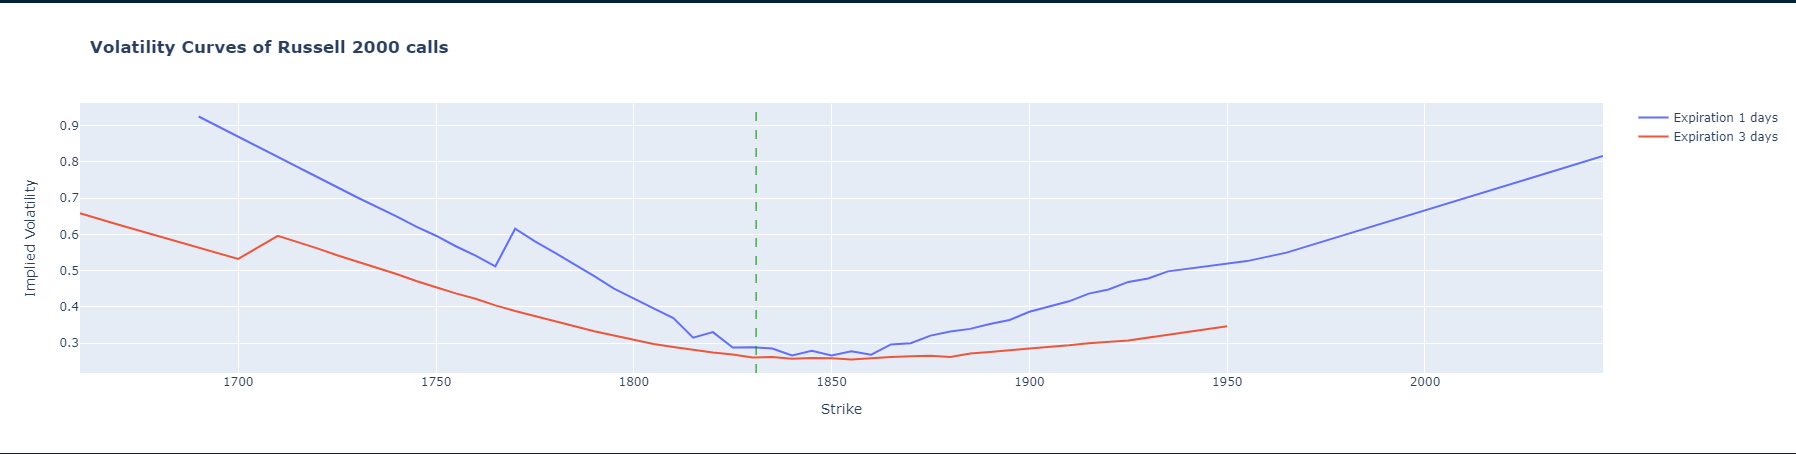

* The Skew: In a volatility skew, the implied volatility tends to be higher for OTM options compared to ATM options. This means that the market expects larger price movements in one direction (e.g., downside) compared to the other direction. The skew is often observed in equity markets where there may be a higher demand for protective put options, leading to increased implied volatility for OTM puts.

In [26]:
expiration1 = 86
df_curve1 = df_calls[df_calls['Time to expiration'] == expiration1].sort_values(by='Strike')

# Filter the DataFrame for the second expiration date
expiration2 = 45
df_curve2 = df_calls[df_calls['Time to expiration'] == expiration2].sort_values(by='Strike')

# Create the first curve
curve1 = go.Scatter(
    x=df_curve1['Strike'],
    y=df_curve1['Implied Volatility'],
    name=f'Expiration {expiration1} days'
)

# Create the second curve
curve2 = go.Scatter(
    x=df_curve2['Strike'],
    y=df_curve2['Implied Volatility'],
    name=f'Expiration {expiration2} days'
)

# Create the plot layout
layout = go.Layout(
    title='<b>Volatility Curves of Russell 2000 calls<b>',
    xaxis=dict(title='Strike'),
    yaxis=dict(title='Implied Volatility')
)

# Create the figure and add the curves
fig = go.Figure(data=[curve1, curve2], layout=layout)

fig.add_vline(x=df_calls.Price_underlying.unique()[0], line_width=1, line_dash="dash", line_color="green")

# Display the plot
fig.show()

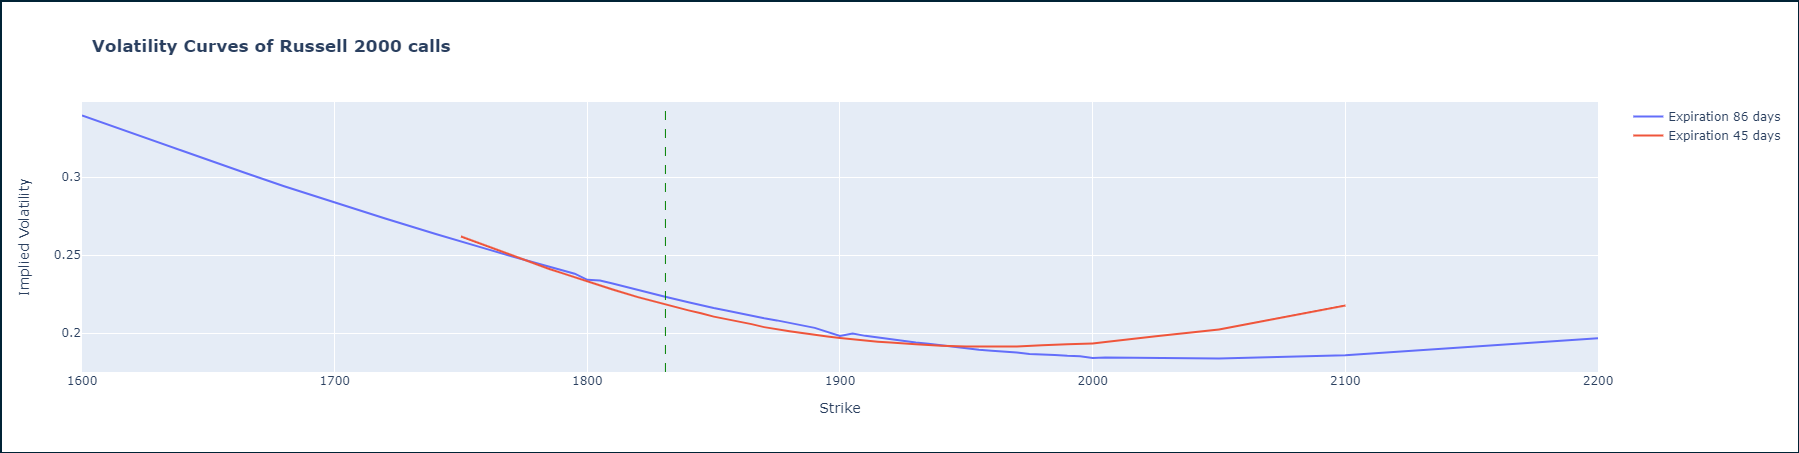

# Calculating the greeks

In [18]:
# Let's assume risk free rate to be the 10yr treasury rate
risk_free_rate = yf.download('^TNX')['Close'][-1]/100
print('The risk free rate assumed is:', risk_free_rate)

[*********************100%***********************]  1 of 1 completed
The risk free rate assumed is: 0.03690999984741211


In [19]:
df_calls['Expiration_date1'] = df_calls['Expiration_date'].astype(str)
df_calls['ID'] = df_calls[['Contract Name', 'Expiration_date1']].agg('-'.join, axis=1)
del df_calls['Expiration_date1']

In [20]:
df_price = {}
df_delta = {}
df_theta = {}
df_vega = {}
df_rho = {}
df_gamma = {}
df_volga = {}
df_vanna = {}
for i,s,k,t,sig in zip(df_calls['ID'],df_calls['Price_underlying'],df_calls['Strike'],df_calls['Time to expiration in years'],df_calls['Implied Volatility']):
    df_price[i] = EuroOpt_BS(S=s, K=k, T=t, r=risk_free_rate, q=0, sigma=sig, Type='Call').price
    df_delta[i] = EuroOpt_BS(S=s, K=k, T=t, r=risk_free_rate, q=0, sigma=sig, Type='Call').delta
    df_theta[i] = EuroOpt_BS(S=s, K=k, T=t, r=risk_free_rate, q=0, sigma=sig, Type='Call').theta
    df_rho[i] = EuroOpt_BS(S=s, K=k, T=t, r=risk_free_rate, q=0, sigma=sig, Type='Call').rho
    df_vega[i] = EuroOpt_BS(S=s, K=k, T=t, r=risk_free_rate, q=0, sigma=sig, Type='Call').vega
    df_gamma[i] = EuroOpt_BS(S=s, K=k, T=t, r=risk_free_rate, q=0, sigma=sig, Type='Call').gamma
    df_volga[i] = EuroOpt_BS(S=s, K=k, T=t, r=risk_free_rate, q=0, sigma=sig, Type='Call').volga
    df_vanna[i] = EuroOpt_BS(S=s, K=k, T=t, r=risk_free_rate, q=0, sigma=sig, Type='Call').vanna

In [21]:
df_price = pd.DataFrame.from_dict(df_price, orient='index').reset_index().rename(columns={0:'Price','index':'ID'})
df_delta = pd.DataFrame.from_dict(df_delta, orient='index').reset_index().rename(columns={0:'Delta','index':'ID'})
df_theta = pd.DataFrame.from_dict(df_theta, orient='index').reset_index().rename(columns={0:'Theta','index':'ID'})
df_rho = pd.DataFrame.from_dict(df_rho, orient='index').reset_index().rename(columns={0:'Rho','index':'ID'})
df_vega = pd.DataFrame.from_dict(df_vega, orient='index').reset_index().rename(columns={0:'Vega','index':'ID'})
df_gamma = pd.DataFrame.from_dict(df_gamma, orient='index').reset_index().rename(columns={0:'Gamma','index':'ID'})
df_volga = pd.DataFrame.from_dict(df_volga, orient='index').reset_index().rename(columns={0:'Volga','index':'ID'})
df_vanna = pd.DataFrame.from_dict(df_vanna, orient='index').reset_index().rename(columns={0:'Vanna','index':'ID'})

In [22]:
df_calls = df_calls.merge(df_price, on='ID', how='left').merge(df_delta, on='ID', how='left').merge(df_theta, on='ID', how='left').merge(df_rho, on='ID', how='left').merge(df_vega, on='ID', how='left').merge(df_gamma, on='ID', how='left').merge(df_volga, on='ID', how='left').merge(df_vanna, on='ID', how='left')

# Analyse greeks behavior

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the column names for the Greeks
greek_columns = ['Delta', 'Theta', 'Rho', 'Vega', 'Gamma', 'Volga', 'Vanna']

# Create subplots using Plotly
fig = make_subplots(rows=3, cols=3, subplot_titles=greek_columns)

# Define colors for ITM and OTM curves
itm_color = 'rgb(0, 31, 85)'
otm_color = 'rgb(169, 26, 0)'

# Loop through the column names and plot each Greek in a subplot
for i, column in enumerate(greek_columns):
    # Calculate the subplot coordinates
    row = i // 3 + 1
    col = i % 3 + 1
    
    # Filter the DataFrame for ITM and OTM options
    itm_df = df_calls[df_calls['Option Moneyness'] == 'ITM']
    otm_df = df_calls[df_calls['Option Moneyness'] == 'OTM']
    
    # Apply rolling average with a window of 200 to smooth the data
    rolling_window = 700
    smoothed_itm_df = itm_df[column].rolling(window=rolling_window, min_periods=1).mean()
    smoothed_otm_df = otm_df[column].rolling(window=rolling_window, min_periods=1).mean()
    
    # Plot ITM and OTM curves with rolling average
    fig.add_trace(go.Scatter(x=itm_df['Time to expiration in years'], y=smoothed_itm_df,
                             name='ITM', line=dict(color=itm_color, width=2), mode='lines',
                             hovertemplate='Time to Expiration: %{x:.2f}<br>%{y}: %{y:.4f}<extra></extra>'),
                  row=row, col=col)
    
    fig.add_trace(go.Scatter(x=otm_df['Time to expiration in years'], y=smoothed_otm_df,
                             name='OTM', line=dict(color=otm_color, width=2), mode='lines',
                             hovertemplate='Time to Expiration: %{x:.2f}<br>%{y}: %{y:.4f}<extra></extra>'),
                  row=row, col=col)

    # Set subplot titles and axis labels
    fig.update_xaxes(title_text='Time to Expiration (Years)', row=row, col=col)
    fig.update_yaxes(title_text=column, row=row, col=col)

# Update layout properties for aesthetics
fig.update_layout(
    title='<b>Greeks with Smoothed Curves<b>',
    height=1000,
    width=1000,
    hovermode='x',
    template='plotly_white'
)

# Add legends to the dashboard
fig.add_trace(go.Scatter(visible=False, name='ITM'), row=1, col=1)
fig.add_trace(go.Scatter(visible=False, name='OTM'), row=1, col=1)

# Display the plot
fig.show()


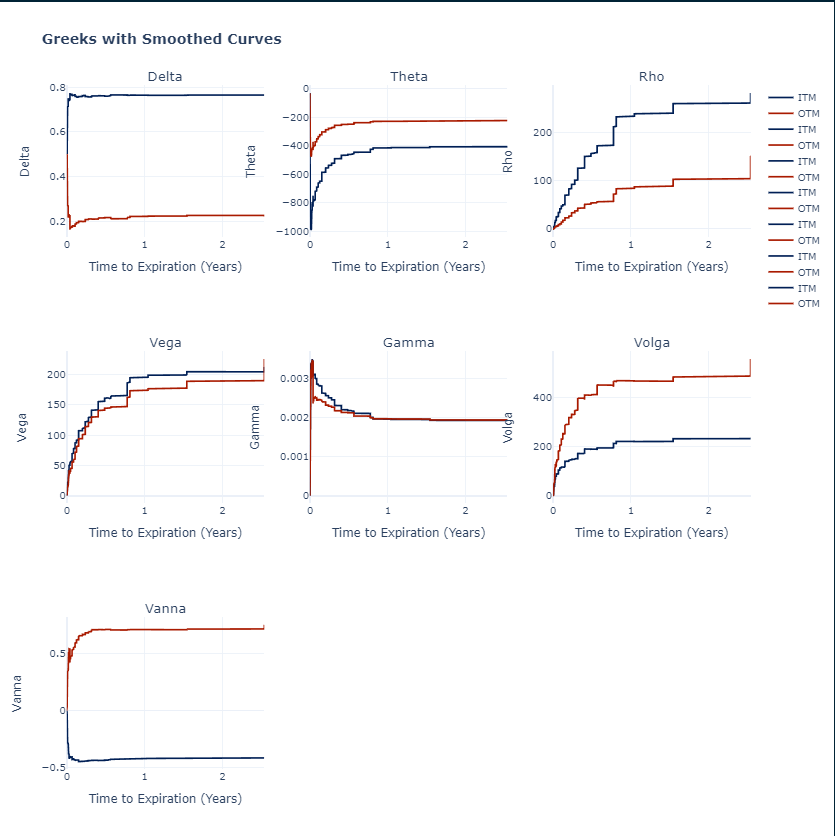

* The delta shows that ITM options have higher deltas then OTM options, in fact, this is expected because the delta can also be represented as the probability of a options expire ITM;
* The theta is negative for both ITM and OTM options, especilly for OTM options with more negative values. This is because ITM options already have intrinsic value, reducing the impact of time decay on their overall value. OTM options, on the other hand, have higher Theta values and are more affected by time decay due to their higher likelihood of expiring worthless if they remain out of the money.
* For the vega, ITM option have higher value than OTM, meaning that changes in implied volatility have a more significant impact on the value of ITM options. This is because ITM options have a higher likelihood of being exercised and, therefore, their value is more influenced by changes in volatility.
* In term of the rho, both ITM and OTM options benefit with rising interest rates.
* ITM options exhibit higher Gamma values, meaning their Delta and value change more rapidly in response to changes in the underlying asset's price. OTM options, on the other hand, have lower Gamma values and are less affected by small changes in the underlying price.
* OTM options show higher volgas than ITM, meaning their Vega and value change more rapidly in response to changes in implied volatility.
* ITM options have higher Vanna values compared to OTM options. This means that as implied volatility changes, ITM options experience larger shifts in their Delta, resulting in a more significant impact on their value.

In [24]:
# Define the column names for the Greeks
greek_columns = ['Delta', 'Theta', 'Rho', 'Vega', 'Gamma', 'Volga', 'Vanna']

# Create subplots using Plotly
fig = make_subplots(rows=3, cols=3, subplot_titles=greek_columns)

# Define colors for curves
color = 'rgb(0, 31, 85)'  # You can change the color to your preference

# Loop through the column names and plot each Greek in a subplot
for i, column in enumerate(greek_columns):
    # Calculate the subplot coordinates
    row = i // 3 + 1
    col = i % 3 + 1
    
    # Sort the DataFrame by strike price and drop NaN values
    df_sorted = df_calls.sort_values('Strike').dropna(subset=[column])
    
    # Apply rolling average with a window of 250 to smooth the data
    rolling_window = 250
    smoothed_df = df_sorted[column].rolling(window=rolling_window, min_periods=1).mean()
    
    # Plot the curve with rolling average as a line plot
    fig.add_trace(go.Scatter(x=df_sorted['Strike'], y=smoothed_df, line=dict(color=color, width=2), mode='lines',
                             hovertemplate='Share Price: %{text}<br>%{y}: %{y:.4f}<extra></extra>',
                             text=df_sorted['Price_underlying']),
                  row=row, col=col)
    
    # Set subplot titles and axis labels
    fig.update_xaxes(title_text='Strike', row=row, col=col)
    fig.update_yaxes(title_text=column, row=row, col=col)

# Update layout properties for aesthetics
fig.update_layout(
    title='<b>Greeks with Smoothed Curves using the Strike price<b>',
    height=800,
    width=1000,
    hovermode='x',
    template='plotly_white'
)

# Display the plot
fig.show()


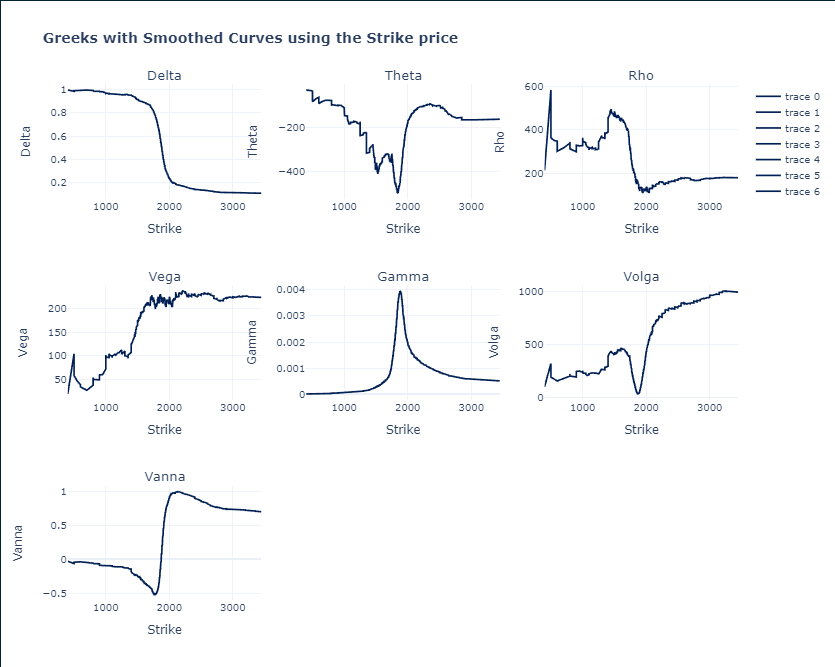

* Delta is higher for lower strike prices and lower for higher strike prices. This means that in-the-money call options have a higher sensitivity to changes in the underlying asset's price compared to out-of-the-money call options.
* Theta is higher for options with shorter time to expiration and decreases as the time to expiration increases. Therefore, options with higher strike prices (OTM) tend to have higher Theta values compared to options with lower strike prices (ITM). OTM call options are more susceptible to time decay.
* Options with lower strike prices tend to have higher Rho values compared to options with higher strike prices.
* OTM options are more sensitive to changes in implied volatility given by the evga. This could be due to higher implied volatility for OTM options, smaller intrinsic value in OTM options, higher reliance on implied volatility for OTM options' value, or market expectations of future volatility.
* Strike prices closer to the current price have higher Gamma values compared to options with strike prices further away.
* The closer to the market price the lower the sensitivity to changes in the vega. Also, OTM options show the highest values, meaning that are the most sensitive to changes in the implied volatility.
* Options with higher Vanna values near at-the-money will have larger changes in their Delta for small price movements in the underlying asset and changes in implied volatility.